In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.cm as cm

from matplotlib.colors import LogNorm
from collections import defaultdict
import random

In [4]:
import torch

In [44]:
import transformers
from transformers import DistilBertConfig, DistilBertModel
from torch.utils.data import DataLoader

In [88]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [6]:
pix_to_m = 0.003175

In [7]:
cluster_dir = './drop_model_movement'
cluster_pattern = 'cluster_*.csv'
csv_files = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))


In [9]:
# alternative csv_files
cluster_dir = './more_data_2025'
cluster_pattern = '*_track_*.csv' 
csv_files1 = sorted(glob.glob(os.path.join(cluster_dir, cluster_pattern)))


In [10]:
# grab old and new csv files

all_csv_files = csv_files + csv_files1

In [9]:
len(all_csv_files)

113

In [11]:


def compute_walkable_mask_with_bounds(
    rect_csv,
    pix_to_m=0.003175,
    resolution=0.2,
    extra_exclude=None
):
    """
    Creates a binary walkable mask of the museum floor, excluding walls, exhibits,
    and any area outside the bounding box of interior features.

    Parameters
    ----------
    rect_csv : str
        Path to floorplan CSV file with rectangle definitions.
    pix_to_m : float
        Conversion factor from pixels to meters.
    resolution : float
        Size of grid cells (in meters).
    extra_exclude : list[str] | None
        Additional labels to exclude if needed.

    Returns
    -------
    mask : 2D bool array
        True where walkable, False where not.
    x_grid, y_grid : 2D float arrays
        Coordinate grid in meters.
    """
    T = pd.read_csv(rect_csv)

    # Step 1: Determine overall floorplan bounds
    x_max = ((T['x'] + T['width']) * pix_to_m).max()
    y_max = ((T['y'] + T['height']) * pix_to_m).max()

    x_coords = np.arange(0, x_max, resolution)
    y_coords = np.arange(0, y_max, resolution)
    x_grid, y_grid = np.meshgrid(x_coords, y_coords)

    mask = np.ones_like(x_grid, dtype=bool)

    # Step 2: Define things to exclude
    default_exclude = ['exit', 'wall_north', 'wall_south', 'wall_west', 'wall_east'] + \
                      [f"exh{i}" for i in range(20)]
    if extra_exclude:
        default_exclude.extend(extra_exclude)

    # Step 3: Exclude interior objects (walls, exhibits)
    for _, row in T.iterrows():
        name = str(row['name']).strip().lower()
        if any(ex in name for ex in default_exclude):
            rx = row['x'] * pix_to_m
            ry = row['y'] * pix_to_m
            rw = row['width'] * pix_to_m
            rh = row['height'] * pix_to_m
            inside_x = (x_grid >= rx) & (x_grid <= rx + rw)
            inside_y = (y_grid >= ry) & (y_grid <= ry + rh)
            mask &= ~(inside_x & inside_y)

    # Step 4: Enforce interior bounding box (exclude outer perimeter)
    interior = T[~T['name'].str.contains('wall', case=False)]
    x0 = (interior['x'] * pix_to_m).min()
    x1 = ((interior['x'] + interior['width']) * pix_to_m).max()
    y0 = (interior['y'] * pix_to_m).min()
    y1 = ((interior['y'] + interior['height']) * pix_to_m).max()

    inside_bounds = (x_grid >= x0) & (x_grid <= x1) & (y_grid >= y0) & (y_grid <= y1)
    mask &= inside_bounds

    return mask, x_grid, y_grid


In [12]:
mask, xg, yg = compute_walkable_mask_with_bounds(
    'drop_model_movement/floor_overlay_labels.csv',
    resolution=0.3
)  # consider changing to a smaller resolution for training

In [13]:
def discretize_walkable_area(mask, xg, yg):
    """
    Converts a walkable binary mask into discrete state grid.

    Parameters
    ----------
    mask : 2D np.array (bool)
        True where walkable.
    xg, yg : 2D np.array
        Meshgrid of X and Y coordinates (same shape as mask).

    Returns
    -------
    state_map : 2D np.array (int)
        Grid of same shape as mask: each walkable cell has a unique state ID,
        non-walkable cells are -1.
    state_lookup : dict[int, tuple[float, float]]
        Maps state ID to (x, y) coordinate center of that state.
    """
    state_map = -1 * np.ones_like(mask, dtype=int)  # default -1 = not walkable
    state_lookup = {}

    state_id = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j]:
                state_map[i, j] = state_id
                state_lookup[state_id] = (xg[i, j], yg[i, j])
                state_id += 1

    return state_map, state_lookup


In [14]:
state_map, state_lookup = discretize_walkable_area(mask, xg, yg)

In [22]:
# grab max states 
NUM_STATES = len(state_lookup)

In [23]:
NUM_STATES

1352

In [24]:
state_map.shape

(37, 69)

In [25]:
# token additions

PAD_ID = 0 #pads trajectories that are shorter than max length with 0s
CLS_ID = 1 # helps aggregate information by indicating start of sequence
UNK_ID = 2 #incase state cant be identified for some reason
OFFSET = 3 
VOCAB_SIZE = OFFSET + NUM_STATES

In [29]:
def get_state_for_position(x, y, x_grid, y_grid, state_map):
    """
    Maps a continuous (x, y) position to its corresponding discrete state ID.
    Returns -1 if out of bounds or non-walkable.
    """
    dx = x_grid[0, 1] - x_grid[0, 0]
    dy = y_grid[1, 0] - y_grid[0, 0]

    col = int((x - x_grid[0, 0]) // dx)
    row = int((y - y_grid[0, 0]) // dy)

    if 0 <= row < state_map.shape[0] and 0 <= col < state_map.shape[1]:
        return state_map[row, col]
    return -1  # out of bounds or non-walkable


def map_trajectory_to_states(x_vals, y_vals, x_grid, y_grid, state_map):
    """
    Maps a full trajectory of (x_vals, y_vals) to a list of discrete state IDs.
    """
    return [get_state_for_position(x, y, x_grid, y_grid, state_map)
            for x, y in zip(x_vals, y_vals)]


In [30]:
# map load and map all clusters to states and make into a pd
def extract_states_traces(csv_file_list, pix_to_m, state_map, xg, yg, OFFSET, CLS= False):
    
    traces = []



    for file in csv_file_list:
        data = pd.read_csv(file)
        x_traj = data.iloc[:, 1] * pix_to_m
        y_traj = data.iloc[:, 2] * pix_to_m
        
        state_trace = map_trajectory_to_states(x_traj, y_traj, xg, yg, state_map)

       
        # # Step 1: Grab visited state IDs (filtering out -1s)
        # visited_state_ids = list(sid for sid in state_trace if sid >= 0)
        # visibilities = [c[sid] for sid in visited_state_ids]

        visited_state_ids = []

        for i, sid in enumerate(state_trace):
            if sid >= 0:
                visited_state_ids.append(sid)
    
        tokens = [sid + OFFSET for sid in visited_state_ids]

        #add cls token at start
        if CLS == True:
            tokens = [CLS_ID] + tokens

        traces.append({
            'traj_id': file,
            'state': visited_state_ids,
            'tokens': tokens,
            'length': len(tokens)


        })
    return pd.DataFrame(traces)
        


In [31]:
data = extract_states_traces(all_csv_files, pix_to_m, state_map, xg, yg, OFFSET)

In [32]:
data.head()

,traj_id,state,tokens,length
0,./drop_model_movement/cluster_001.csv,"[282, 282, 283, 283, 283, 229, 229, 283, 283, ...","[285, 285, 286, 286, 286, 232, 232, 286, 286, ...",10288
1,./drop_model_movement/cluster_002.csv,"[1304, 1304, 1304, 1304, 1304, 1304, 1304, 130...","[1307, 1307, 1307, 1307, 1307, 1307, 1307, 130...",32171
2,./drop_model_movement/cluster_003.csv,"[241, 241, 241, 241, 241, 241, 241, 241, 241, ...","[244, 244, 244, 244, 244, 244, 244, 244, 244, ...",2265
3,./drop_model_movement/cluster_004.csv,"[191, 191, 191, 191, 192, 191, 191, 191, 191, ...","[194, 194, 194, 194, 195, 194, 194, 194, 194, ...",1989
4,./drop_model_movement/cluster_007.csv,"[187, 187, 187, 187, 187, 187, 187, 188, 188, ...","[190, 190, 190, 190, 190, 190, 190, 191, 191, ...",3893


In [33]:
# train/cv split on data
rng = np.random.default_rng(42)  # for reproducibility
rng.shuffle(all_csv_files)

n = int(0.9 * len(all_csv_files))
train_csvs = all_csv_files[:n]
val_csvs   = all_csv_files[n:]

In [34]:
# perform chunking seperately for train and cv
CHUNK_SIZE = 100
TOTAL_LEN = CHUNK_SIZE + 1 # +1 for CLS token

#add tracking information for troubleshooting/clustering later
#for train
#access tokens for train csvs, in data

train_chunks = []
for train_csv in train_csvs:
    tokens = data.loc[data['traj_id'] == train_csv, 'tokens'].iloc[0]

    chunk_idx = 0
    for start in range(0, len(tokens), CHUNK_SIZE):
        chunk_tokens = tokens[start:start + CHUNK_SIZE]
        if len(chunk_tokens) == 0:
            continue

        chunk = [CLS_ID] + chunk_tokens
        assert chunk[0] == CLS_ID
        assert len(chunk) <= TOTAL_LEN

        train_chunks.append({
            "traj_id": train_csv,      # or os.path.basename(train_csv)
            "chunk_idx": chunk_idx,
            "start": start,            # where this chunk begins in the original tokens
            "tokens": chunk,
            "length": len(chunk),
        })
        chunk_idx += 1



# for test set
val_chunks = []
for val_csv in val_csvs:
    tokens = data.loc[data['traj_id'] == val_csv, 'tokens'].iloc[0]

    chunk_idx = 0
    for start in range(0, len(tokens), CHUNK_SIZE):
        chunk_tokens = tokens[start:start + CHUNK_SIZE]
        if len(chunk_tokens) == 0:
            continue

        chunk = [CLS_ID] + chunk_tokens
        assert chunk[0] == CLS_ID
        assert len(chunk) <= TOTAL_LEN

        val_chunks.append({
            "traj_id": val_csv,
            "chunk_idx": chunk_idx,
            "start": start,
            "tokens": chunk,
            "length": len(chunk),
        })
        chunk_idx += 1

#no padding, attension masks, or tensors at this point

In [35]:
len(train_chunks)

3833

In [36]:
# collate function, pads tokens, puts them in batches, and converts them to tensor format for model compatibility
# input ids need to be (B x T), batch size x sequence length
#need an attention mask to indicate which tokens are padding and which are real

def collate_encoder_chunks(batch, pad_id=PAD_ID, pad_to_len=101, return_meta=True):
    """
    Collate function for encoder-only models (e.g., DistilBERT encoder).

    batch: list of dicts, each like:
      {
        "traj_id": str,
        "chunk_idx": int,
        "start": int,
        "tokens": list[int],   # starts with CLS_ID, length <= pad_to_len
        "length": int (optional; we can recompute)
      }

    Returns:
      input_ids:      LongTensor (B, T)
      attention_mask: LongTensor (B, T) with 1 for real tokens, 0 for PAD
      meta: dict of lists (optional)
    """
    if len(batch) == 0:
        raise ValueError("Empty batch passed to collate_encoder_chunks.")

    # Extract sequences
    seqs = [item["tokens"] for item in batch]
    lengths = [len(s) for s in seqs]

    T = int(pad_to_len) if pad_to_len is not None else max(lengths)
    B = len(seqs)

    # Allocate padded tensors
    input_ids = torch.full((B, T), pad_id, dtype=torch.long)
    attention_mask = torch.zeros((B, T), dtype=torch.long)

    # Fill
    for i, s in enumerate(seqs):
        if len(s) == 0:
            continue
        if len(s) > T:
            # Since you control chunking, this should not happen; truncate defensively.
            s = s[:T]
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, dtype=torch.long)
        attention_mask[i, :L] = 1

    meta = None
    if return_meta:
        meta = {
            "traj_id":   [item.get("traj_id") for item in batch],
            "chunk_idx": [item.get("chunk_idx") for item in batch],
            "start":     [item.get("start") for item in batch],
            "length":    lengths,
        }

    return input_ids, attention_mask, meta


In [ ]:
###checking if collate function works
input_ids, attention_mask, meta = collate_encoder_chunks(train_chunks[-100:-1], pad_to_len=101)

In [40]:
# checking if 0s in attention mask
num_zeros = (attention_mask == 0).sum(dim=1)
print(num_zeros)

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0, 86,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0, 48,  0,  0,  0,  0,  0,  0,  0, 25,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0])


In [52]:
###### using dataloader to create batches for training and validation

train_loader = DataLoader(
    train_chunks,
    batch_size=32,          # you can start small, e.g. 8 or 16
    shuffle=True,           # important for training; ok for testing too
    collate_fn=lambda b: collate_encoder_chunks(
        b,
        pad_id=PAD_ID,
        pad_to_len=TOTAL_LEN
    )
)

val_loader = DataLoader(
    val_chunks,
    batch_size=32,
    shuffle=True,          # no need to shuffle validation data
    collate_fn=lambda b: collate_encoder_chunks(
        b,
        pad_id=PAD_ID,
        pad_to_len=TOTAL_LEN
    )
)


In [53]:
## set device to GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [54]:
# initialize DistilBERT config with custom vocab size and max position embeddings
config = DistilBertConfig(
    vocab_size=VOCAB_SIZE,           # e.g. 1355
    max_position_embeddings=101,     # TOTAL_LEN
)

In [55]:
#instantiate the model
model = DistilBertModel(config)
model.to(device) #moves model to gpu
model.eval() 

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(1355, 768, padding_idx=0)
    (position_embeddings): Embedding(101, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [ ]:
#making sure it works on mac
print(next(model.parameters()).device)


mps:0


In [60]:
# turns a batch of tokenized chunks into a batch of vector embeddings


#generates a batch from the train loader
batch = next(iter(train_loader))
input_ids, attention_mask, meta = batch

# move tensors to device (MPS)
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)


with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

H = outputs.last_hidden_state #embedding of every token at every position
z = H[:, 0, :] #grabs the CLS embedding for each chun


In [61]:
print(input_ids.shape)        # (B, 101)
print(attention_mask.shape)   # (B, 101)
print(H.shape)                # (B, 101, hidden_dim)
print(z.shape)  

torch.Size([32, 101])
torch.Size([32, 101])
torch.Size([32, 101, 768])
torch.Size([32, 768])


In [62]:
# evaluate model, extract all CLS embeddings for all chunks in train and val set, just a forward pass, cluster using umap, analyze
#model.eval() # no dropout, no gradients, deterministic outputs

def extract_cls_embeddings(
    model,
    loader,
    device,
    *,
    desc: str = "extract",
):
    """
    run encoder in eval/no_grad mode and extract CLS embeddings for every chunk.

    Assumes each batch from `loader` yields:
      input_ids: (B, T) LongTensor
      attention_mask: (B, T) LongTensor or BoolTensor
      meta: dict with keys: 'traj_id', 'chunk_idx', 'start', 'length'
    Returns:
      Z:        (N_chunks, hidden_dim) torch.FloatTensor on CPU
      meta_df:  pandas DataFrame with one row per chunk (aligned with Z rows)
    """
    model.eval()

    Z_parts = []
    meta_rows = []

    with torch.no_grad():
        for input_ids, attention_mask, meta in loader:
            # Move tensors to device
            input_ids = input_ids.to(device, non_blocking=True)
            attention_mask = attention_mask.to(device, non_blocking=True)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # CLS embedding: position 0
            z = outputs.last_hidden_state[:, 0, :]   # (B, hidden_dim)

            # Store embeddings on CPU
            Z_parts.append(z.detach().cpu())

            # Store aligned metadata rows
            B = z.shape[0]
            for j in range(B):
                meta_rows.append({
                    "traj_id":   meta["traj_id"][j],
                    "chunk_idx": meta["chunk_idx"][j],
                    "start":     meta["start"][j],
                    "length":    meta["length"][j],
                })

    Z = torch.cat(Z_parts, dim=0) if len(Z_parts) else torch.empty((0, model.config.dim))
    meta_df = pd.DataFrame(meta_rows)

    assert len(meta_df) == Z.shape[0], "Metadata rows must align with embeddings rows."
    return Z, meta_df




In [ ]:

Z_train, meta_train = extract_cls_embeddings(model, train_loader, device, desc="train")
Z_val,   meta_val   = extract_cls_embeddings(model, val_loader, device, desc="val")

print("Z_train:", Z_train.shape, "meta_train:", meta_train.shape)
print("Z_val:  ", Z_val.shape,   "meta_val:  ", meta_val.shape)

# Optional quick checks
print(meta_train.head())
print("Train chunks per traj (top 5):")
print(meta_train["traj_id"].value_counts().head())

Z_train: torch.Size([3833, 768]) meta_train: (3833, 4)
Z_val:   torch.Size([535, 768]) meta_val:   (535, 4)
                                        traj_id  chunk_idx  start  length
0         ./drop_model_movement/cluster_017.csv         16   1600     101
1  ./more_data_2025/20220825_track_00676_BA.csv          1    100     101
2         ./drop_model_movement/cluster_012.csv         44   4400     101
3  ./more_data_2025/20220825_track_00463_BB.csv         48   4800     101
4  ./more_data_2025/20220825_track_01532_AB.csv          6    600     101
Train chunks per traj (top 5):
traj_id
./drop_model_movement/cluster_002.csv           322
./drop_model_movement/cluster_012.csv           322
./more_data_2025/20220825_track_00822_AB.csv    199
./more_data_2025/20220825_track_00526_BA.csv    181
./more_data_2025/20220826_track_00030_AB.csv    121
Name: count, dtype: int64


In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


Z = Z_train.numpy() # convert to numpy for UMAP

scaler = StandardScaler()
Zs = scaler.fit_transform(Z)

K = 50  # start with something like 20–200
kmeans = KMeans(n_clusters=K, n_init="auto", random_state=42)
cluster_id = kmeans.fit_predict(Zs)

meta_train = meta_train.copy()
meta_train["cluster"] = cluster_id

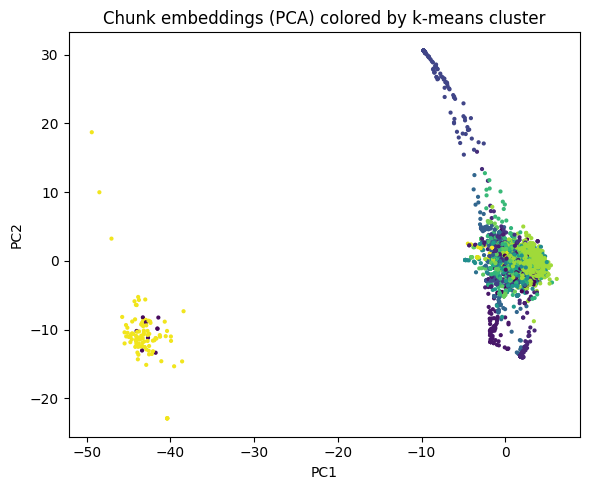

In [ ]:
###this is all an excercise before training, just to see if i can indeed cluster the embeddings, and everything is working

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=3, random_state=42)
Z2 = pca.fit_transform(Zs)

plt.figure(figsize=(6, 5))
plt.scatter(Z2[:, 0], Z2[:, 1], c=cluster_id, s=4)
plt.title("Chunk embeddings (PCA) colored by k-means cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

- Interesting that even with untrained embbedding, the pca shows two distinct clusters, is this an artifact?

decide on training loss function

In [ ]:
#MLM loss function
#masks parts of input sequence and tries to predict them
#recquires addtional data processing step
#and model with MLM head

In [79]:
# Keep everything already have
# PAD_ID = 0, CLS_ID = 1, UNK_ID = 2, OFFSET = 3 

MASK_ID = VOCAB_SIZE            # new id not used before
VOCAB_SIZE_MLM = VOCAB_SIZE + 1 # extend vocab by 1

In [80]:
VOCAB_SIZE_MLM

1356

In [77]:
mx = max(max(ch["tokens"]) for ch in train_chunks if len(ch["tokens"]) > 0)

print("max token:", mx, "VOCAB_SIZE:", VOCAB_SIZE, "MASK_ID:", MASK_ID)
assert mx < VOCAB_SIZE

max token: 1353 VOCAB_SIZE: 1355 MASK_ID: 1355


In [ ]:
from transformers import DistilBertForMaskedLM

In [91]:


# config = DistilBertConfig(
#     vocab_size=VOCAB_SIZE_MLM,
#     max_position_embeddings=TOTAL_LEN,  # 101
# ) #same setting were defined before, now using it on MLM model

mlm_model = DistilBertForMaskedLM(config).to(device)

In [82]:

def collate_mlm_from_chunks(batch, *, pad_id, cls_id, mask_id, pad_to_len=101, mlm_prob=0.15):
    # batch can be a list of chunks OR list of dicts.
    if isinstance(batch[0], dict):
        seqs = [b["tokens"] for b in batch]
        meta = {
            "traj_id":   [b.get("traj_id") for b in batch],
            "chunk_idx": [b.get("chunk_idx") for b in batch],
            "start":     [b.get("start") for b in batch],
        }
    else:
        seqs = batch
        meta = {"traj_id": [None]*len(batch), "chunk_idx": [None]*len(batch), "start": [None]*len(batch)}

    lengths = [len(s) for s in seqs]
    B = len(seqs)
    T = pad_to_len

    input_ids = torch.full((B, T), pad_id, dtype=torch.long)
    attention_mask = torch.zeros((B, T), dtype=torch.long)

    for i, s in enumerate(seqs):
        s = s[:T]
        L = len(s)
        input_ids[i, :L] = torch.tensor(s, dtype=torch.long)
        attention_mask[i, :L] = 1

    # MLM labels
    labels = input_ids.clone()

    # mask candidates: real tokens, not PAD, not CLS
    can_mask = (attention_mask == 1) & (input_ids != pad_id) & (input_ids != cls_id)

    # sample which positions to mask
    mask_positions = (torch.rand((B, T)) < mlm_prob) & can_mask

    # compute loss only on masked positions
    labels[~mask_positions] = -100

    # replace inputs at masked positions with MASK token
    input_ids[mask_positions] = mask_id

    meta["length"] = lengths
    return input_ids, attention_mask, labels, meta


In [90]:
# new data loaders for MLM training


#curbing randomness for reproducibility
g = torch.Generator()
g.manual_seed(SEED)


mlm_train_loader = DataLoader(
    train_chunks,            # same chunks that were already built
    batch_size=32,
    shuffle=True,
    generator=g,
    collate_fn=lambda b: collate_mlm_from_chunks(
        b, pad_id=PAD_ID, cls_id=CLS_ID, mask_id=MASK_ID, pad_to_len=TOTAL_LEN, mlm_prob=0.15
    ),
)

mlm_val_loader = DataLoader(
    val_chunks,
    batch_size=32,
    shuffle=False, # TODO: no need to shuffle validation data, why?
    collate_fn=lambda b: collate_mlm_from_chunks(
        b, pad_id=PAD_ID, cls_id=CLS_ID, mask_id=MASK_ID, pad_to_len=TOTAL_LEN, mlm_prob=0.15
    ),
)

In [84]:
from torch.optim import AdamW

In [92]:
#training loop for MLM model

optimizer = AdamW(mlm_model.parameters(), lr=3e-4, weight_decay=0.01)

for epoch in range(10):
    mlm_model.train()
    total = 0.0
    nb = 0

    for input_ids, attention_mask, labels, meta in mlm_train_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        out = mlm_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total += loss.item()
        nb += 1

    print(f"epoch {epoch} train loss: {total/max(nb,1):.4f}")

    mlm_model.eval()
    vtotal = 0.0
    vnb = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels, meta in mlm_val_loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            out = mlm_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            vtotal += out.loss.item()
            vnb += 1

    print(f"epoch {epoch} val loss: {vtotal/max(vnb,1):.4f}")


epoch 0 train loss: 4.0355
epoch 0 val loss: 3.0012
epoch 1 train loss: 1.6609
epoch 1 val loss: 1.2072
epoch 2 train loss: 0.8463
epoch 2 val loss: 0.6530
epoch 3 train loss: 0.6381
epoch 3 val loss: 0.5838
epoch 4 train loss: 0.5553
epoch 4 val loss: 0.5200
epoch 5 train loss: 0.5260
epoch 5 val loss: 0.5175
epoch 6 train loss: 0.5031
epoch 6 val loss: 0.4926
epoch 7 train loss: 0.4816
epoch 7 val loss: 0.5013
epoch 8 train loss: 0.4784
epoch 8 val loss: 0.4546
epoch 9 train loss: 0.4653
epoch 9 val loss: 0.4726


In [97]:
# extract embeddings from trained MLM model

encoder = mlm_model.distilbert


Z_train_tr, meta_train_tr = extract_cls_embeddings(encoder, train_loader, device, desc="train (trained)")
Z_val_tr,   meta_val_tr   = extract_cls_embeddings(encoder, val_loader,   device, desc="val (trained)")

In [98]:
Z = Z_train_tr.numpy()

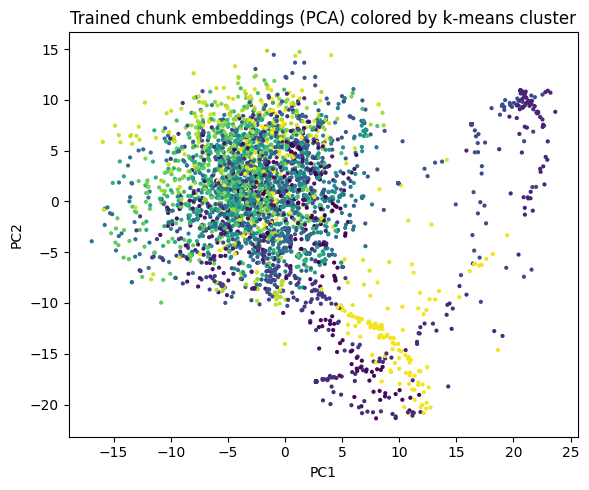

In [99]:
Zs = StandardScaler().fit_transform(Z)

K = 50
cluster_id = KMeans(n_clusters=K, n_init="auto", random_state=42).fit_predict(Zs)

meta_train_tr = meta_train_tr.copy()
meta_train_tr["cluster"] = cluster_id

Z2 = PCA(n_components=2, random_state=42).fit_transform(Zs)

plt.figure(figsize=(6,5))
plt.scatter(Z2[:,0], Z2[:,1], c=cluster_id, s=4)
plt.title("Trained chunk embeddings (PCA) colored by k-means cluster")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.show()

In [100]:
# umap
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Zs = scaler.fit_transform(Z)

In [102]:
import umap.umap_ as umap

umap_model = umap.UMAP(
    n_neighbors=50,      
    min_dist=0.05,       # smaller → tighter clusters
    n_components=2,
    metric="euclidean",
    random_state=42,
)

Z_umap = umap_model.fit_transform(Zs)   # (N, 2)

/Users/iuliarusu/miniconda3/envs/huggingfacetut/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


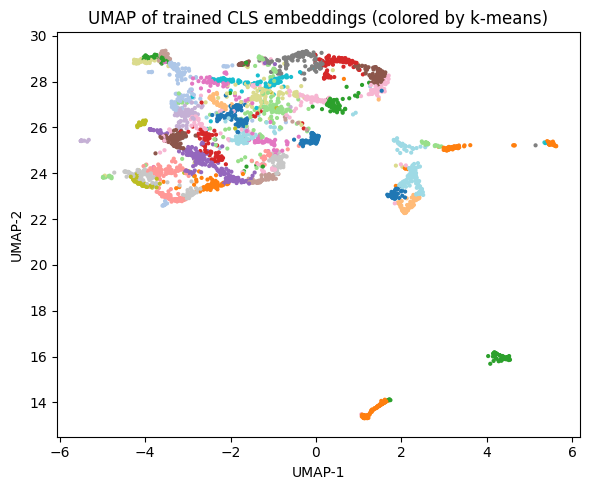

In [103]:
plt.figure(figsize=(6, 5))
plt.scatter(
    Z_umap[:, 0],
    Z_umap[:, 1],
    c=meta_train_tr["cluster"],
    s=4,
    cmap="tab20"
)
plt.title("UMAP of trained CLS embeddings (colored by k-means)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

In [107]:
import matplotlib.lines as mlines

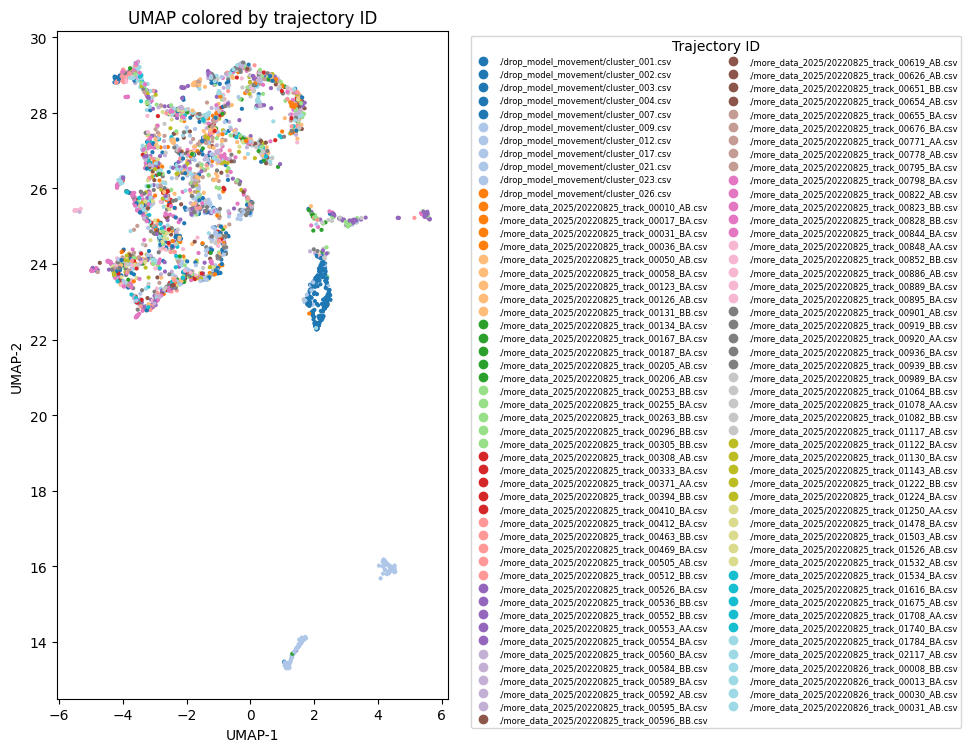

In [109]:

traj_cat = pd.Categorical(meta_train_tr["traj_id"])
traj_codes = traj_cat.codes
traj_labels = traj_cat.categories

plt.figure(figsize=(10, 8))

sc = plt.scatter(
    Z_umap[:, 0],
    Z_umap[:, 1],
    c=traj_codes,
    s=4,
    cmap="tab20",   # will cycle colors
)

plt.title("UMAP colored by trajectory ID")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

handles = []
for i, label in enumerate(traj_labels):
    handles.append(
        mlines.Line2D(
            [], [],
            color=sc.cmap(sc.norm(i)),
            marker='o',
            linestyle='None',
            markersize=6,
            label=str(label)
        )
    )

plt.legend(
    handles=handles,
    title="Trajectory ID",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=6,        # <-- crucial
    ncol=2             # <-- helps readability
)

plt.tight_layout()
plt.show()


# Trained Model Troubleshoot

In [ ]:
# plot reconstructions



# reconstruction error, mean squared error from predicted x,y positions to true positions, can keep baseline loss

# The Plan

train an encoder model on my state representations
extract the trained, latent space embeddings
 
for a single chunk, find its z representation for every token or its CLS embedding
use umap to discretize z space to signify a 'latent state', these are now the for looped s
feed latent state into maxent irl
figure out a P(s'|s,a) through sampling,  P( latent s'| latetent s, a), sample all a's, becomes nondeterministic
run pipeline, get pi(action | latent state) 

